Assignment Overview
-----------------------------------

### 6.1 Assignment: Build a Baseline Model

### Objective:
You will enhance the classification model previously built in the session to predict loan defaults using the Lending Club dataset. Please use the 100k row sample as starting point for your model.  

#### Part 1 - Mandatory
Build a second model, `model_2`:
- selecting additional variables
- performing feature engineering (feel free to use features engineered previously)
- performing cross-validation 
- dealing with class imbalance 
- any additional techniques you would like to add to improve your model, at your discretion 

Compare it to `model` by using the evaluation metrics covered in this session.

#### Part 2 - Optional
As a data scientist working for the business, your objective is to **minimize the average cost of default** and **maximize the average income on loans**. Optimise `model_2` on this basis, leveraging a **custom loss function** (see 7.2 below) and considering the **following information on the cost of misclassifying** unseen observations:
##### Misclassification cost, and importance of False Positives and False Negatives:
-   **False Positives (FP)**: Predicting a loan as default when it is not. This can lead to lost opportunities for the lender since a potentially profitable loan is denied. Given the **FP_cost = 100**, the cost is relatively low, but it can accumulate over multiple instances.

-   **False Negatives (FN)**: Predicting a loan as non-default when it actually defaults. This is much more severe because it results in financial loss to the lender. Given the **FN_cost = 1000**, the cost here is much higher, reflecting the significant impact of a loan defaulting when it was predicted otherwise.


### Tips:
-   **Feature Engineering**: Explore new features that might improve model performance. You may want or need to use some of the techniques covered in session 3.
-   **Cross-Validation**: Implement cross-validation to ensure your model does not overfit to the training data.
-   **Threshold Adjustment**: Consider adjusting the decision threshold to balance false positives and false negatives based on the associated costs.

### Deliverables:

-   A Jupyter Notebook containing:
    -   Detailed explanations of feature selection and engineering.
    -   Cross-validation implementation.
    -   Final model performance evaluation using custom loss metrics (FP_cost and FN_cost).
    -   Part 2 (optional): Custom loss function implementation and loss optimisation



### Set up

In [5]:
python_material_folder_name = "python-material"

#### Import libraries

In [7]:
#Import library
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = "/Users/hisay/Desktop/Courses/DSFinance/Data_Science_in_Finance_Resources/python-material"

# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv")
df.head()

#Read the dictionary file
df_dictionary = pd.read_excel(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/LCDataDictionary.xlsx")

# Convert to Markdown format
from IPython.display import Markdown
markdown_table = df_dictionary.to_markdown(index=False)  
#print("\n Here is the Dictionary for the list of the variables \n")
#display(Markdown(markdown_table))  # Display as Markdown 

### Removal of unwanted columns



In [9]:
#Drop the Unnamed columns, just for the convenience
list_to_drop = ['Unnamed: 0.1', 'Unnamed: 0']#YOUR CODE HERE
df_new = df.drop(list_to_drop, axis= 1)
df_new.shape

(100000, 141)

In [10]:
#Display the updated datafranm
df_new.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,167338079,4000.0,4000.0,4000.0,36 months,13.08%,134.93,B,B5,cashier,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,71016917,24000.0,24000.0,24000.0,60 months,9.16%,500.07,B,B2,ABM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,39589826,5000.0,5000.0,5000.0,36 months,10.49%,162.49,B,B3,driver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,134798709,24000.0,24000.0,24000.0,60 months,11.05%,522.42,B,B4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,127097355,14000.0,14000.0,14000.0,60 months,13.59%,322.79,C,C2,Shipping Clerk,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### <span style = 'color: BLUE'> Exploratory data analysis

Here, I analyze the loan status to categorize the defaulter, non-defaulters and others.

*<span style = 'color: BLUE'>Useful definitions:*  
- *Defaulted Loan: A loan is considered in default when the borrower fails to make the required payments as agreed in the loan contract. Default typically occurs after missing several payments (usually 90 to 180 days, depending on the type of loan and lender policies).*
- *A loan is charged off when the lender writes off the loan as a bad debt on their financial statements, recognizing it as a loss. This typically happens after the loan has been in default for a significant period, often around 180 days.*

In [12]:
#The loan status
df_new.loan_status.value_counts()

loan_status
Fully Paid                                             51189
Current                                                35294
Charged Off                                            12384
Late (31-120 days)                                       535
In Grace Period                                          329
Late (16-30 days)                                         90
Does not meet the credit policy. Status:Fully Paid        69
Issued                                                    63
Does not meet the credit policy. Status:Charged Off       33
Default                                                   14
Name: count, dtype: int64

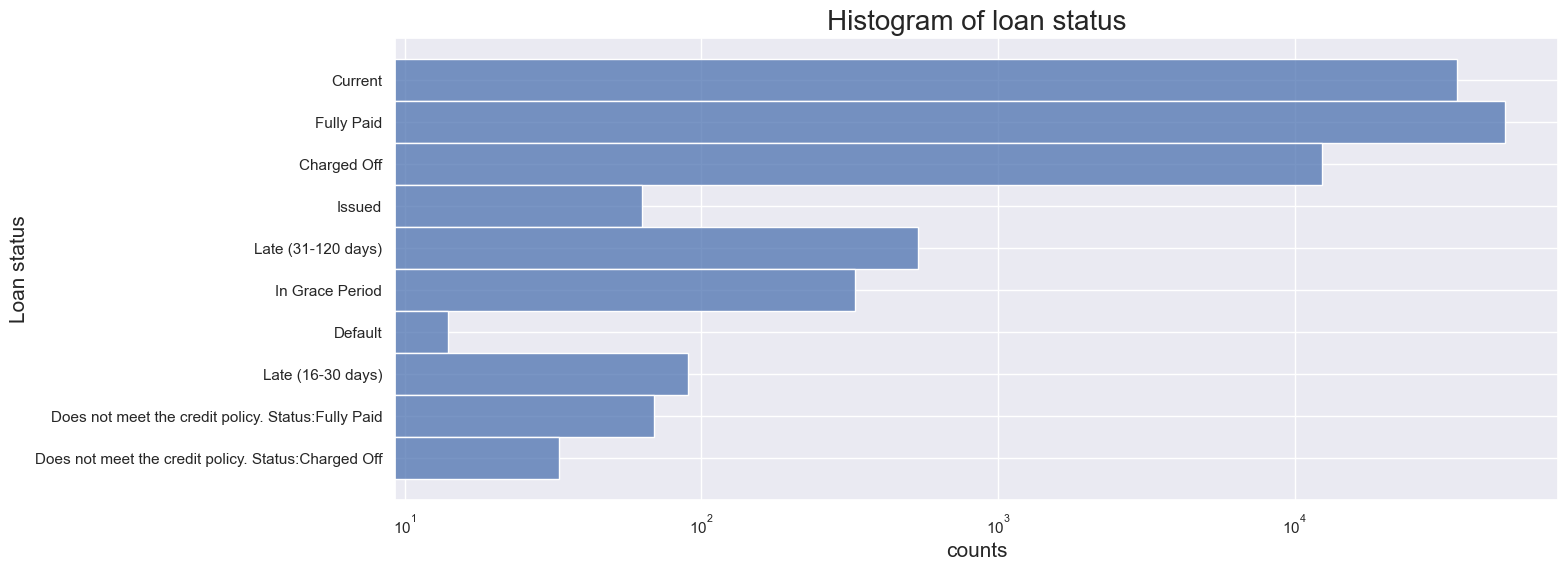

In [13]:
#Histogram plot
sns.set(rc={'figure.figsize':(15,6)})
sns.histplot(y = df['loan_status'], bins = 20)
plt.xscale('log')
plt.title("Histogram of loan status", fontsize=20)
plt.xlabel("counts", fontsize=15)
plt.ylabel("Loan status", fontsize=15);
plt.show()

Text(0, 0.5, 'Loan Status')

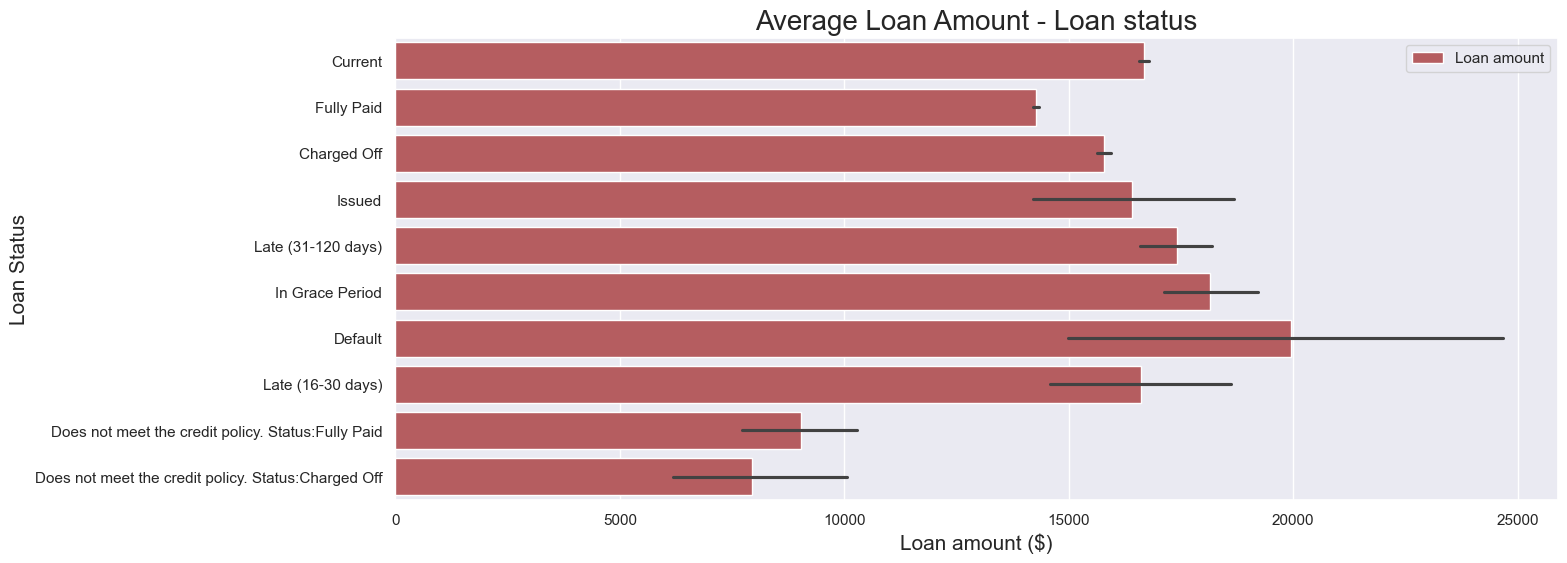

In [14]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'loan_amnt', y = 'loan_status', data = df_new, label = "Loan amount", color = "r")
plt.title("Average Loan Amount - Loan status", fontsize=20)
plt.xlabel("Loan amount ($)", fontsize=15)
plt.ylabel("Loan Status", fontsize=15)

The plot clearly indicates that defaults are associated with higher loan amounts, typically exceeding 20,000 USD. Conversely, loans under 8,000 USD tend to fall into the "Does not meet credit policy" category, while those between 8,000 USD and 17,000 USD are spread across the remaining categories.

Text(0, 0.5, 'Loan Status')

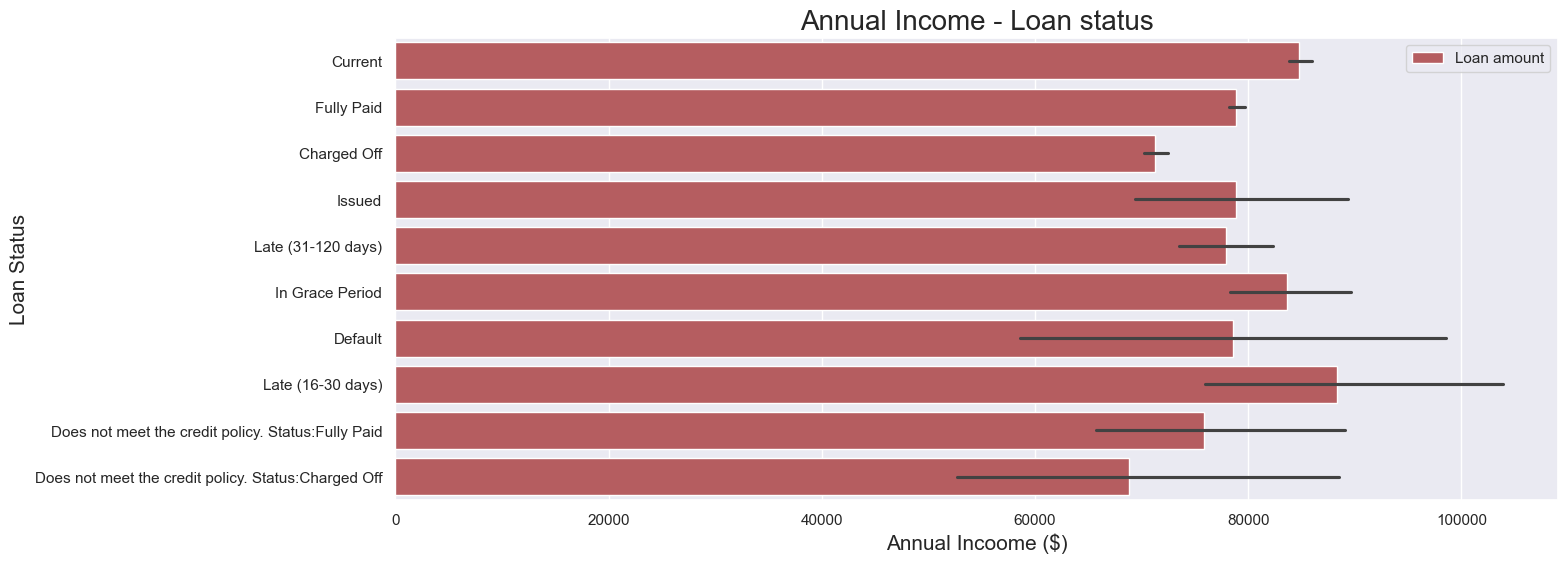

In [16]:
import seaborn as sns
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'annual_inc', y = 'loan_status', data = df_new, label = "Loan amount", color = "r")
plt.title("Annual Income - Loan status", fontsize=20)
plt.xlabel("Annual Incoome ($)", fontsize=15)
plt.ylabel("Loan Status", fontsize=15)

We will break this plot later. 

Let's check whether type of application (individual or joint application) has any dependence on the loan amount.

In [18]:
#application type
num_unique = df_new["application_type"].unique()
print(num_unique)

['Individual' 'Joint App']


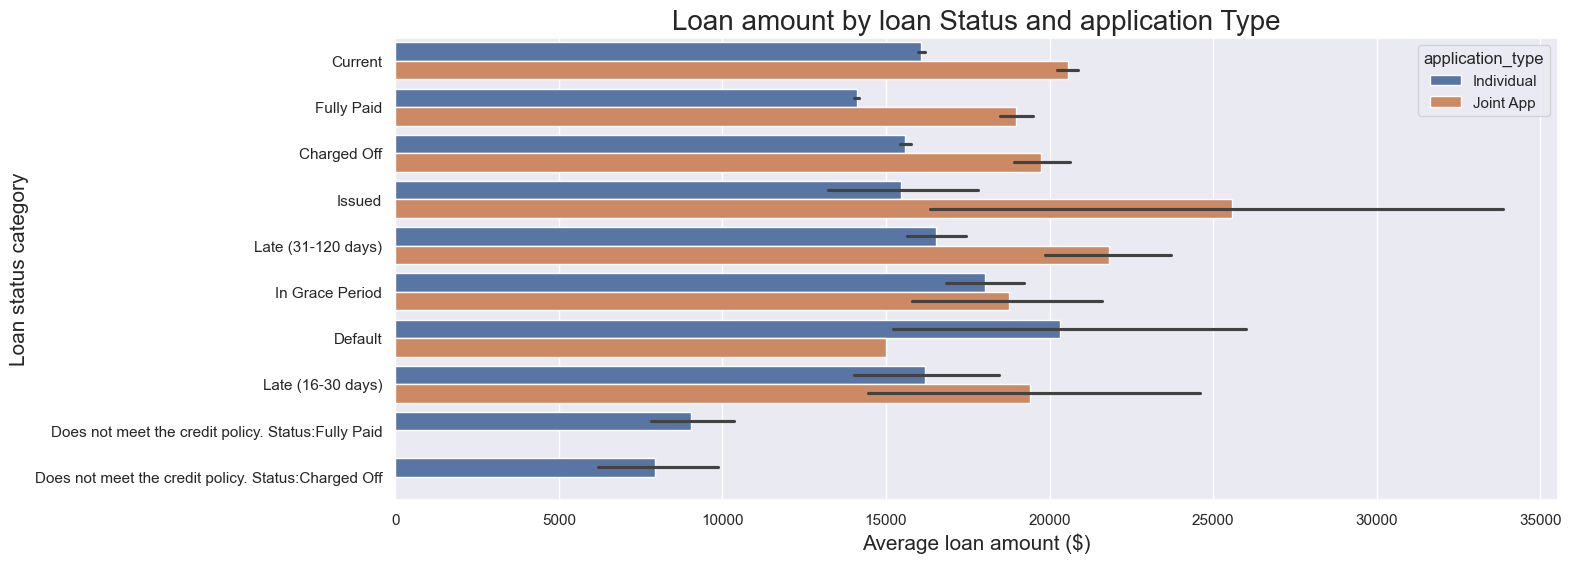

In [19]:
sns.set(rc={'figure.figsize': (15, 6)})
sns.barplot(y='loan_status', 
            x='loan_amnt', 
            hue='application_type', 
            data=df_new)
plt.title("Loan amount by loan Status and application Type", fontsize=20)
plt.ylabel("Loan status category", fontsize=15)
plt.xlabel("Average loan amount ($)", fontsize=15)
plt.show()

The higher loan was given to the joint application type applicant that's apparent. Lets see their density in the violin plot:

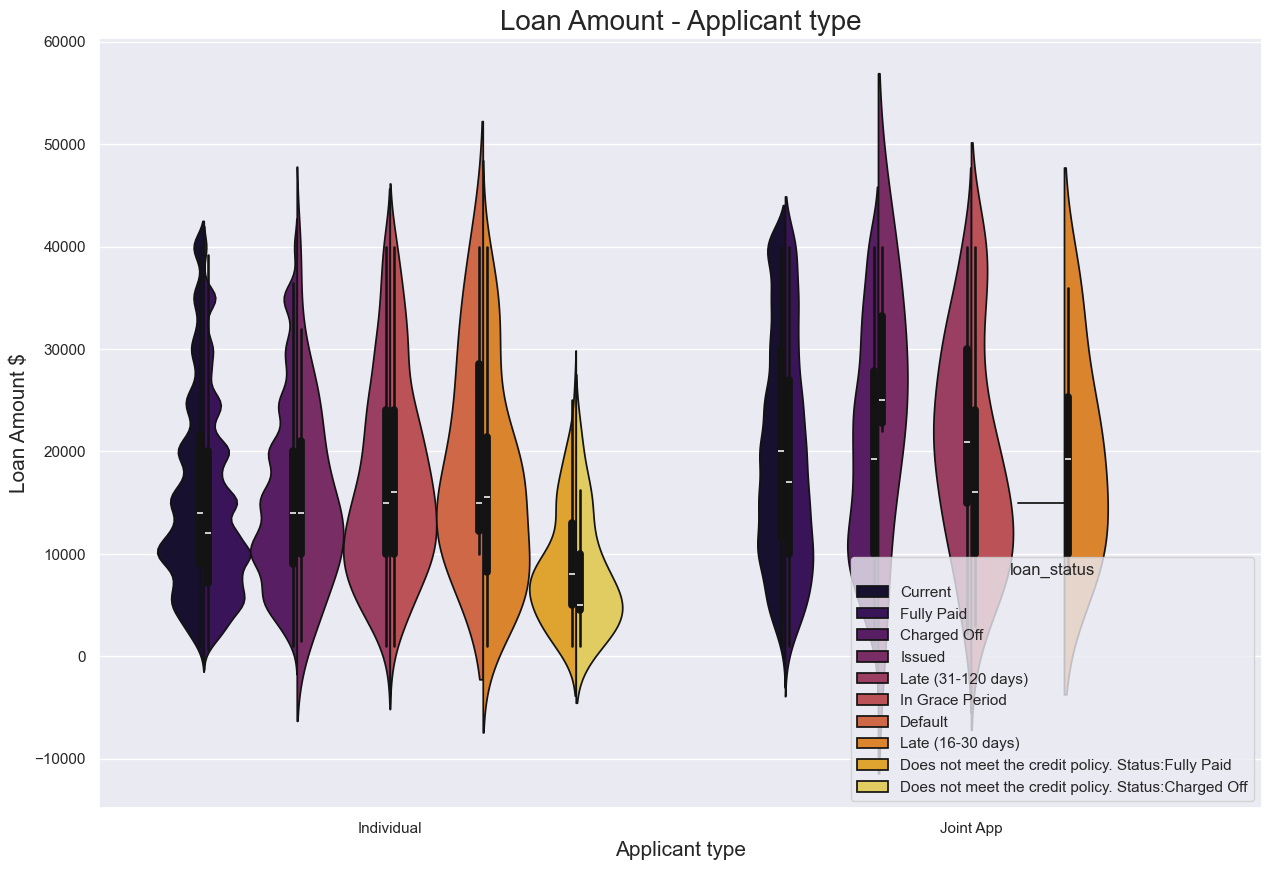

In [21]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="application_type",y="loan_amnt",data=df_new, 
               hue="loan_status", split=True,palette='inferno')
plt.title("Loan Amount - Applicant type", fontsize=20)
plt.xlabel("Applicant type", fontsize=15)
plt.ylabel("Loan Amount $", fontsize=15);

Some negative values of numeric data in the `loan amounts` were  detected, which requires some data cleaning at a later stage. `Defaults` are less with Joint type applicants.

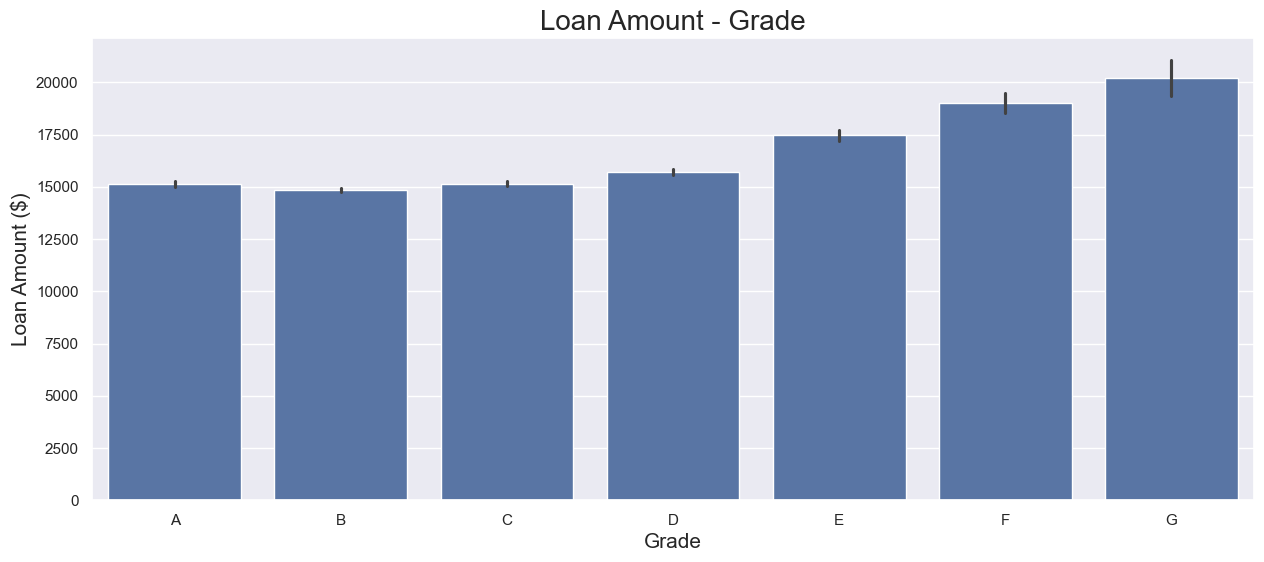

In [23]:
#Let's study now loan grades
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'loan_amnt', data = df_new, order="ABCDEFG")
plt.title("Loan Amount - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Loan Amount ($)", fontsize=15);

**Next, I combine the small-case and large-case labels in the data, as they are currently treated as separate labels.**

The column `grades` is assigned based on the average loan amount. For example `A` - 15000 \$ to `G` - 20000$, which shows that the highest grade equates to the greater loan amount. Now let's check how `interest rate` and `term` relates to the `grade`.

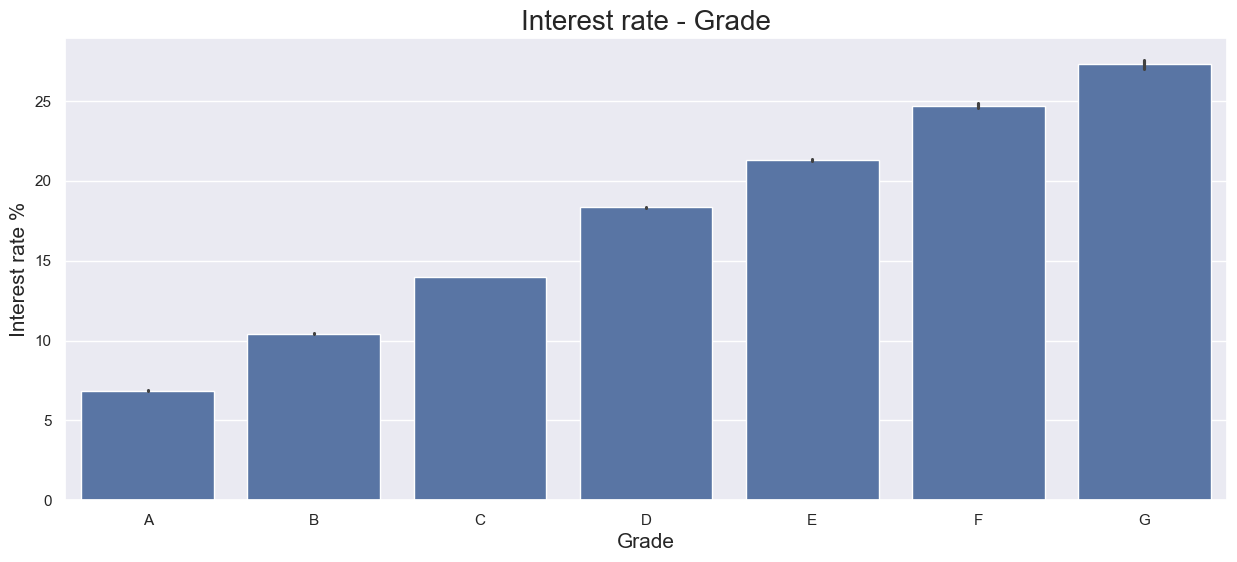

In [26]:
#I first chnaged the alpha numeric columns to a numeric columns
df_new['term_numeric'] = df_new['term'].str.extract(r'(\d+)').astype(int)
df_new['int_rate_numeric'] = df_new['int_rate'].str.extract(r'(\d+)').astype(int)

#sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'int_rate_numeric', data = df_new, order="ABCDEFG")
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest rate %", fontsize=15);

It's apparent that the `Grade` is given based on the interest rate. Higher the interest rate, the higher the grade.

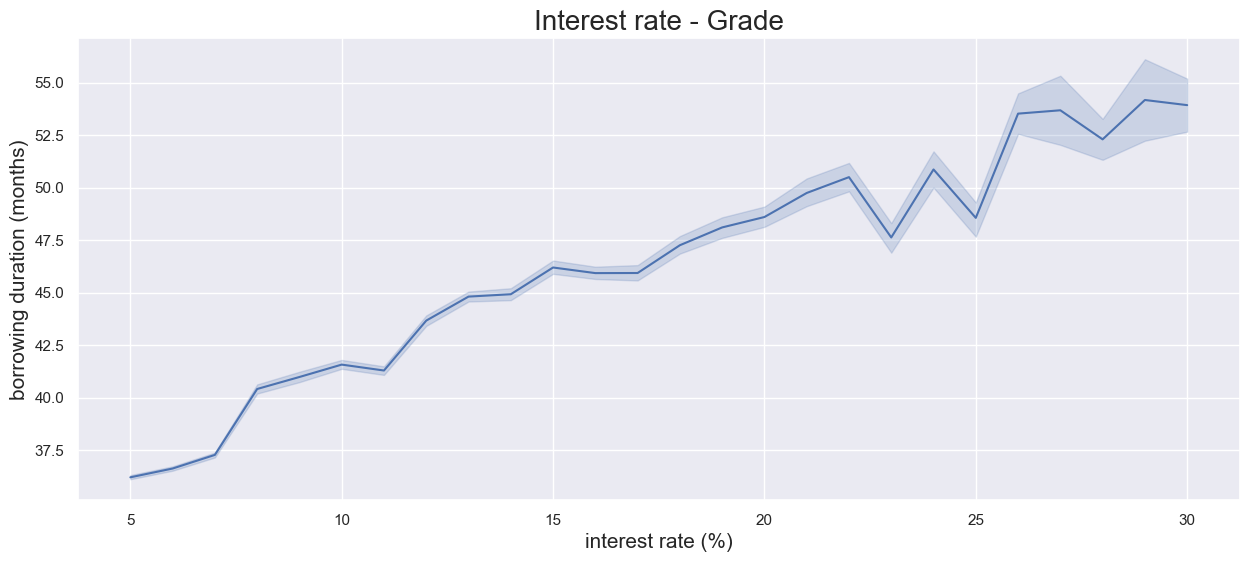

In [28]:
#sns.set(rc={'figure.figsize':(15,6)})
sns.lineplot(x = 'int_rate_numeric', y = 'term_numeric', data = df_new)
plt.title("Interest rate - Grade", fontsize=20)
plt.xlabel("interest rate (%)", fontsize=15)
plt.ylabel("borrowing duration (months)", fontsize=15);

This suggests that, on average, borrowers with longer loan durations are assigned higher interest rates.

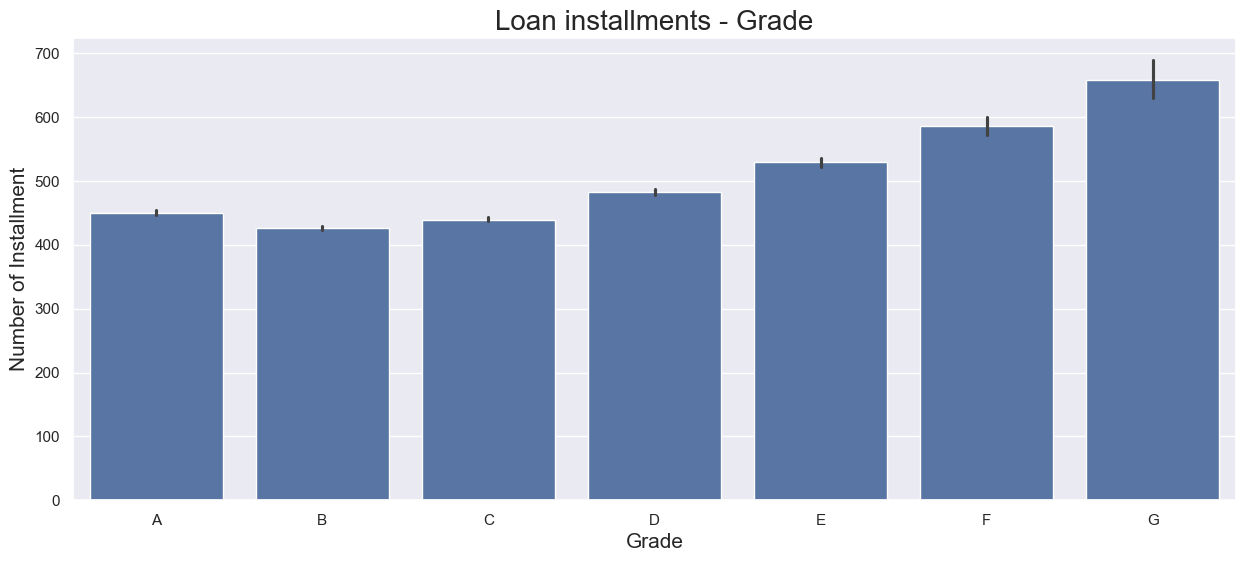

In [30]:
sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x = 'grade', y = 'installment', data = df_new, order="ABCDEFG")
plt.title("Loan installments - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Number of Installment", fontsize=15);

Therefore, the number of installements are greater for higher loan which G grade.

### <span style = 'color: BLUE'> 2. Feature selection

Based on our exploratory data analysis, let's select a few important variables from the dataset for our analysis. 

<span style="color:BLUE"> **Most Important Variables for Loan Approval**
- `id`$\rightarrow$ ID number for borrower
- `annual_inc` $\rightarrow$  Self-reported annual income
- `loan_amnt` $\rightarrow$  Loan amount requested
- `loan_status` $\rightarrow$  Loan status (Fully Paid, Charged Off, Late, Default)
- `term` $\rightarrow$  Duration for loan repayment (36 or 60 months) (converted to numeric)
- `application_type` $\rightarrow$  Application type (Individual type or joint type)
- `int_rate`$\rightarrow$ interest rate (converted to numeric)
- `grades` $\rightarrow$ loan grades
- `installment` $\rightarrow$ The monthly payment amount.
- `(fico_range_high + fico_range_low)/2` $\rightarrow$  FICO credit score  - we will create them for our analysis

---
<span style='color:BLUE'>Some other variables (may be important):
- `pub_rec_bankruptcies` $\rightarrow$  Number of bankruptcies recorded
- `home_ownership` $\rightarrow$  MORTGAGE, RENT, OWN (Financial status)
- `out_prncp_inv` $\rightarrow$  Remaining outstanding principal
- `purpose` $\rightarrow$  Reason for loan (e.g., credit card debt consolidation, home improvement)
- `recoveries` $\rightarrow$ Amount recovered from charged-off loans.
- `emp_length` $\rightarrow$ Employment length



These variables help **assess risk**, determine the **borrower’s ability to repay**, and predict **loan performance**.

## <span style = 'color: BLUE'> Task 2

In [34]:
#Make a clean data frame with the most important columns
df_clean = df_new[["id", "annual_inc","loan_amnt", "term_numeric",
                   "int_rate_numeric", "emp_length", "loan_status"]]

df_clean.head()       

,id,annual_inc,loan_amnt,term_numeric,int_rate_numeric,emp_length,loan_status
0,167338079,48000.0,4000.0,36,13,10+ years,Current
1,71016917,57000.0,24000.0,60,9,6 years,Current
2,39589826,55000.0,5000.0,36,10,10+ years,Fully Paid
3,134798709,43500.0,24000.0,60,11,NaN,Current
4,127097355,48000.0,14000.0,60,13,10+ years,Fully Paid


In [35]:
df_selected = df_new[["loan_amnt", "annual_inc", 
                      "emp_length", "loan_status","int_rate_numeric", "term_numeric"]]

df_selected = df_selected.copy() #make the modification in the copy
df_selected["interest_collected"] = (df_new["loan_amnt"] * df_new["int_rate_numeric"] * df_new["term_numeric"] / 100)

df_selected.loc[:, "interest_collected"] = (
    df_new["loan_amnt"] * df_new["int_rate_numeric"] * df_new["term_numeric"] / 100
)
#print("Display the number of unique categories in the home_ownership:")
#print(df_selected["loan_status"].value_counts())
print("\n----")
print("Display the number of nulls in the respective columns:")
print(df_selected.isnull().sum())


----
Display the number of nulls in the respective columns:
loan_amnt                0
annual_inc               0
emp_length            6950
loan_status              0
int_rate_numeric         0
term_numeric             0
interest_collected       0
dtype: int64


In [36]:
#We remove all the rows with the missing values or nan
df_selected_new = df_selected.dropna(axis = 0)
df_selected_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93050 entries, 0 to 99998
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   loan_amnt           93050 non-null  float64
 1   annual_inc          93050 non-null  float64
 2   emp_length          93050 non-null  object 
 3   loan_status         93050 non-null  object 
 4   int_rate_numeric    93050 non-null  int64  
 5   term_numeric        93050 non-null  int64  
 6   interest_collected  93050 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 5.7+ MB


In [37]:
#Now lets convert the employment duration into a numeric value
df_selected = df_selected_new.copy()
df_selected_new.loc[:, "emp_length_numeric"] = df_selected_new["emp_length"].str.extract(r'(\d+)').astype(int)
df_selected_new.head()

,loan_amnt,annual_inc,emp_length,loan_status,int_rate_numeric,term_numeric,interest_collected,emp_length_numeric
0,4000.0,48000.0,10+ years,Current,13,36,18720.0,10
1,24000.0,57000.0,6 years,Current,9,60,129600.0,6
2,5000.0,55000.0,10+ years,Fully Paid,10,36,18000.0,10
4,14000.0,48000.0,10+ years,Fully Paid,13,60,109200.0,10
5,4000.0,46000.0,10+ years,Charged Off,11,36,15840.0,10


In [38]:
#We convert the categorical variable (home_ownership), only consider the rows with the mortgagee, rent or own
df_1 = df_selected_new[df_selected_new["loan_status"].isin(["Charged Off", "Fully Paid"])]
df_1.head()

,loan_amnt,annual_inc,emp_length,loan_status,int_rate_numeric,term_numeric,interest_collected,emp_length_numeric
2,5000.0,55000.0,10+ years,Fully Paid,10,36,18000.0,10
4,14000.0,48000.0,10+ years,Fully Paid,13,60,109200.0,10
5,4000.0,46000.0,10+ years,Charged Off,11,36,15840.0,10
6,7200.0,33000.0,6 years,Fully Paid,13,36,33696.0,6
7,19500.0,99000.0,2 years,Fully Paid,17,36,119340.0,2


In [39]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(df_1[["loan_status"]])
encoded_df = pd.DataFrame(encoded_features, 
                          columns=encoder.get_feature_names_out(['loan_status'])).astype(int)

# Merge the encoded features with the rest of the data
df_encoded = pd.concat([df_1.drop(columns=['loan_status']), encoded_df], axis=1)
df_encoded.head()

,loan_amnt,annual_inc,emp_length,int_rate_numeric,term_numeric,interest_collected,emp_length_numeric,loan_status_Charged Off,loan_status_Fully Paid
2,5000.0,55000.0,10+ years,10.0,36.0,18000.0,10.0,1.0,0.0
4,14000.0,48000.0,10+ years,13.0,60.0,109200.0,10.0,0.0,1.0
5,4000.0,46000.0,10+ years,11.0,36.0,15840.0,10.0,1.0,0.0
6,7200.0,33000.0,6 years,13.0,36.0,33696.0,6.0,0.0,1.0
7,19500.0,99000.0,2 years,17.0,36.0,119340.0,2.0,0.0,1.0


### <span style = 'color: BLUE'> Feautre selection



In [41]:
features = ['annual_inc', "interest_collected", 'emp_length_numeric', 'loan_amnt']
X = df_encoded[features]
y = df_encoded['loan_status_Charged Off']#, 'loan_status_Fully Paid'
X1 = X.dropna()
y1 = y.loc[X1.index] 

y2 = y1.dropna()
X2 = X1.loc[y2.index]  # Align y with X_clean
print("Shape after dropping NaNs:", X2.shape)

Shape after dropping NaNs: (35528, 4)


In [42]:
X2.head()

,annual_inc,interest_collected,emp_length_numeric,loan_amnt
2,55000.0,18000.0,10.0,5000.0
4,48000.0,109200.0,10.0,14000.0
5,46000.0,15840.0,10.0,4000.0
6,33000.0,33696.0,6.0,7200.0
7,99000.0,119340.0,2.0,19500.0


### <span style ='color: BLUE'> 3. Model development

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2,y2, 
                                                    test_size = 0.2, random_state=42)

for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")

Shape: (28422, 4)
Shape: (7106, 4)
Shape: (28422,)
Shape: (7106,)


In [45]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 10000, solver= 'lbfgs')
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [46]:
# Predict on the test set
predictions = model.predict(X_test)
predictions

array([0., 0., 0., ..., 0., 0., 0.])

### 4. <span style = 'color: BLUE'>Model evaluation

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions,zero_division=0)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC-AUC: {roc_auc}')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 0.8148043906557838
Precision: 0.0
Recall: 0.0
F1-Score: 0.0
ROC-AUC: 0.5033246321348515
Confusion Matrix:
[[5790    0]
 [1316    0]]


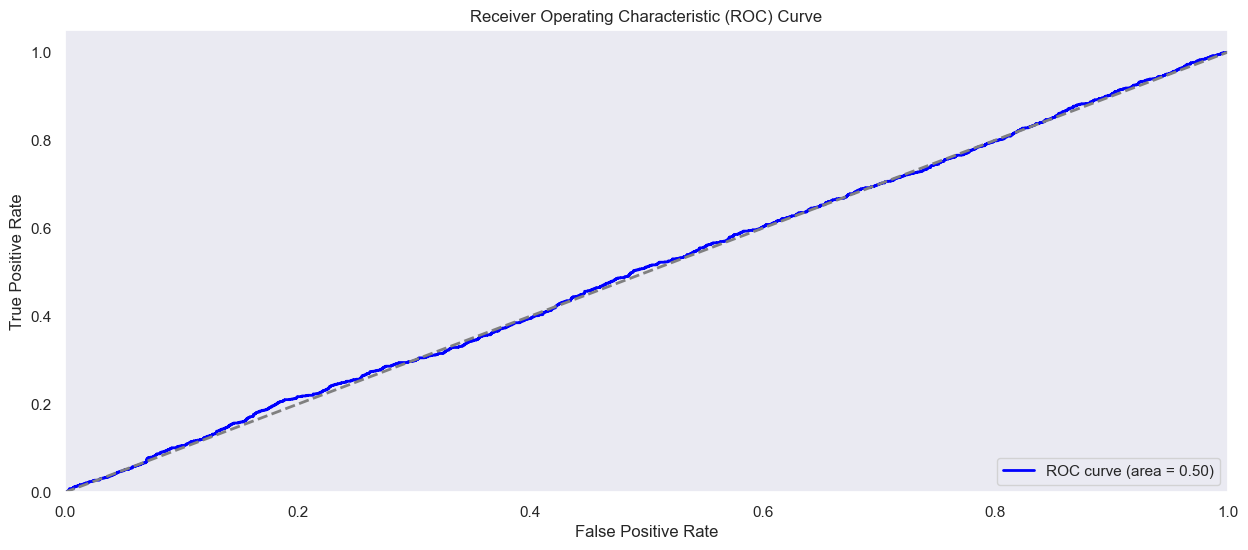

ROC AUC Score: 0.50


In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Assuming you have a trained model and test data (X_test, y_test)
# Replace these with your actual data and model
# Example: model = LogisticRegression().fit(X_train, y_train)
# Example: y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute predicted probabilities (for the positive class)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob):.2f}')

### <span style = 'color: BLUE'> Approach - 1
In the following section, I aimed to enhance the model's ability to predict defaulters. To achieve this, I first **normalized** the input features to ensure they are consistent with the binarized values.


In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X2,y2, 
                                                    test_size = 0.2, random_state=42)

for dframe in [X_train, X_test, y_train, y_test]:
    print(f"Shape: {dframe.shape}")
    
# A pipeline and train Logistic Regression with class weighting
model_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced',
                                  max_iter=5000, solver='saga', random_state=42))])
# Fit the model
model_1.fit(X_train, y_train)

Shape: (28422, 4)
Shape: (7106, 4)
Shape: (28422,)
Shape: (7106,)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    random_state=42, solver='saga'))])

In [52]:
# Predict on the test set
y_pred_1 = model_1.predict(X_test)
y_pred_1

array([1., 1., 0., ..., 0., 0., 0.])

In [53]:
# Calculate metrics
accuracy1 = accuracy_score(y_test, y_pred_1)
precision1 = precision_score(y_test, y_pred_1,zero_division=0)
recall1 = recall_score(y_test, y_pred_1)
f2 = f1_score(y_test, predictions)
roc_auc1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:,1])

# Display the confusion matrix
cm1 = confusion_matrix(y_test, y_pred_1)

print(f'Accuracy: {accuracy1}')
print(f'Precision: {precision1}')
print(f'Recall: {recall1}')
print(f'F1-Score: {f2}')
print(f'ROC-AUC: {roc_auc1}')
print(f'Confusion Matrix:\n{cm1}')

Accuracy: 0.4434280889389248
Precision: 0.18440564458263572
Recall: 0.5858662613981763
F1-Score: 0.0
ROC-AUC: 0.5016609052396176
Confusion Matrix:
[[2380 3410]
 [ 545  771]]


Confusion matrix contents were improved as we can see some true flase negatives too. However, ROC curve haven't improved much. 

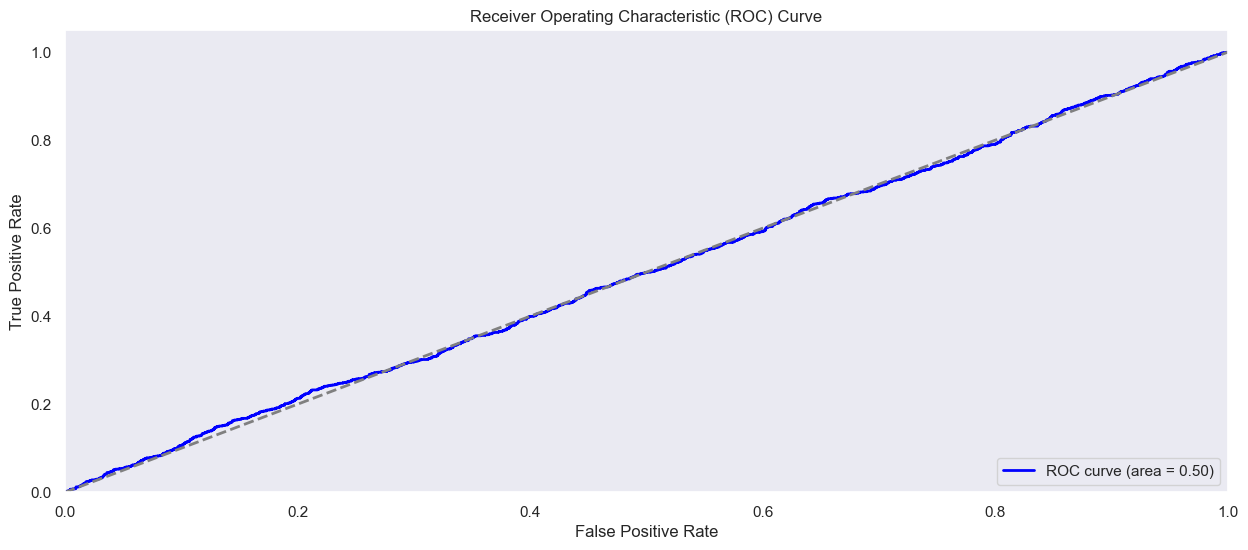

ROC AUC Score: 0.50


In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute predicted probabilities (for the positive class)
y_pred_prob_1 = model_1.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC AUC
fpr1, tpr1, thresholds = roc_curve(y_test, y_pred_prob_1)
roc_auc1 = auc(fpr1, tpr1)

# Plot ROC curve
plt.figure()
plt.plot(fpr1, tpr1, color='blue', lw=2, label=f'ROC curve (area = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test, y_pred_prob_1):.2f}')


### <span style = 'color: BLUE'> Approach - 2
Use class_weight parameter

In [57]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix


X22 = X2
y22 = y2
# Create an imbalanced dataset (a synthetic dataset with 90:10) ratio
X22, y22 = make_classification(
    n_samples=1000,       # Total number of samples
    n_features=20,        # Number of features
    n_informative=2,      # Number of informative features
    n_redundant=10,       # Number of redundant features
    n_clusters_per_class=1,
    weights=[0.9, 0.1],   # Imbalance ratio
    flip_y=0,             # No noise
    random_state=1        # Reproducibility
)

#splitting the datasets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X22, y22, test_size=0.2, random_state=1)

#Initialize the Logistic regression
class_weight='balanced'
model_2 = LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs')

# Train the model
model_2.fit(X_train2, y_train2)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [58]:
y_pred_2 = model_2.predict(X_test2)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test2, y_pred_2))

print("Confusion Matrix:")
print(confusion_matrix(y_test2, y_pred_2))

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       178
           1       0.51      0.82      0.63        22

    accuracy                           0.90       200
   macro avg       0.75      0.86      0.79       200
weighted avg       0.92      0.90      0.90       200

Confusion Matrix:
[[161  17]
 [  4  18]]


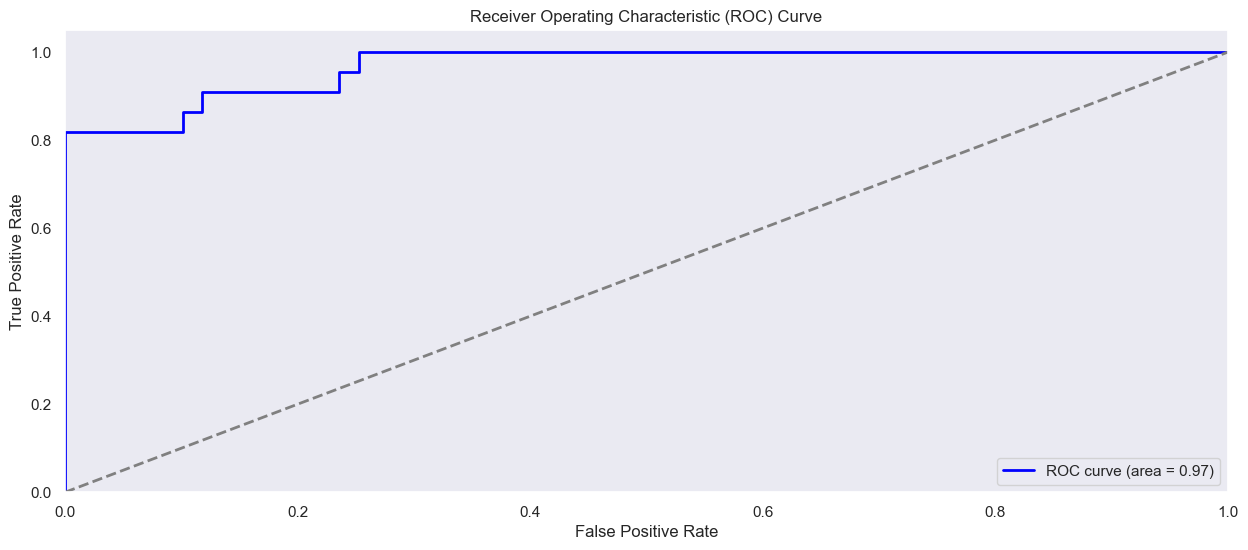

ROC AUC Score: 0.97


In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute predicted probabilities (for the positive class)
y_pred_prob_2 = model_2.predict_proba(X_test2)[:, 1]

# Compute ROC curve and ROC AUC
fpr2, tpr2, thresholds = roc_curve(y_test2, y_pred_prob_2)
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curve
plt.figure()
plt.plot(fpr2, tpr2, color='blue', lw=2, label=f'ROC curve (area = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line (random prediction)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Additional stats
print(f'ROC AUC Score: {roc_auc_score(y_test2, y_pred_prob_2):.2f}')

### <span style = 'color: BLUE'>Approach 3

### **Custom loss functions**

**What is a custom loss function?**
A custom loss function is a user-defined function that specifies how errors should be penalized during model training, tailored to the specific goals or constraints of a problem. Unlike standard loss functions that might only minimize general error (like MSE or cross-entropy), custom loss functions can assign different weights to different types of errors based on their real-world impact. For instance, you might want to penalize loan defaults more heavily than missed profit opportunities, ensuring that the model's predictions align with the financial implications of errors.

**Implementation in Python (logistic regression)** 
In scikit-learn, you cannot directly minimize a custom loss function during the training of a logistic regression model because it uses predefined loss functions like log loss (cross-entropy) during optimization.

You can only adjust the model after training by fine-tuning thresholds based on your custom loss, for example:


In [101]:
# Train logistic regression model
# model = LogisticRegression()
# model.fit(X, y)

# # Predictions
# y_pred_prob = model.predict_proba(X)[:, 1]
# threshold = 0.5  # Default threshold

# # Custom thresholding based on custom loss function
# FP_cost = 1.0  # Cost for False Positive
# FN_cost = 5.0  # Cost for False Negative

# def custom_threshold(y_pred_prob, threshold):
#     return np.where(y_pred_prob > threshold, 1, 0)

# def evaluate_custom_loss(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     loss = FP_cost * fp + FN_cost * fn
#     return loss

# # Calculate loss for the default threshold
# y_pred_default = custom_threshold(y_pred_prob, threshold)
# default_loss = evaluate_custom_loss(y, y_pred_default)

# print(f"Default Loss: {default_loss}")
#
model

LogisticRegression()

In [107]:
#Train the logistic regression model
model.fit(X2, y2)

# Predictions
y_pred_prob_3 = model.predict_proba(X2)[:,1]
threshold = 0.5 #Default threshold

#Custom thresholding based on custom loss functions === How its chosen?
FP_cost = 1.0  # Cost for False Positive
FN_cost = 5.0  # Cost for False Negative

def custom_threshold(y_pred_prob, threshold):
    return np.where(y_pred_prob > threshold, 1, 0)

def evaluate_custom_loss(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    loss = FP_cost * fp + FN_cost * fn
    return loss

# Calculate loss for the default threshold
y_pred_default = custom_threshold(y_pred_prob_3, threshold)
default_loss = evaluate_custom_loss(y2, y_pred_default)

print(f"Default Loss: {default_loss}")

Default Loss: 33785.0


In [117]:
#Optimizing the decision threshold using the custom loss

# Custom loss function parameters
FP_cost = 100  # Cost for False Positive
FN_cost = 1000  # Cost for False Negative

def custom_loss(y_true, y_pred, threshold):
    y_pred_bin = (y_pred > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    return FP_cost * fp + FN_cost * fn

# Evaluate model for various thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
losses = [custom_loss(y2, y_pred_prob_3, t) for t in thresholds]

# Select the threshold with the minimum loss
best_threshold = thresholds[np.argmin(losses)]
best_loss = min(losses)

print(f"Best Threshold: {best_threshold}")
print(f"Lowest Custom Loss: {best_loss}")


Best Threshold: 0.1
Lowest Custom Loss: 2877000
